## Listons les importations

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import joblib

## Les données

Nous avons choisi de d'utiliser application_train.csv, car c'est une grande souce de données qui nous servira à prédire les crédits.

In [2]:
df = pd.read_csv('data/application_train.csv')

Visualisons nos données.

In [3]:
df = df.set_index('Identifiant du client')
colonnes_a_supprimer = df.filter(regex='^Unnamed').columns
df = df.drop(columns=colonnes_a_supprimer)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Columns: 121 entries, Cible (0 = non défaut, 1 = défaut) to Montant demandé à l'agence de crédit (année)
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


In [5]:
df.head(1)

,"Cible (0 = non défaut, 1 = défaut)",Type de contrat,Code du genre,Indicateur de propriété d'une voiture,Indicateur de propriété immobilière,Nombre d'enfants,Revenu total,Montant du crédit,Montant de l'annuité,Prix des biens,...,Indicateur du document 18,Indicateur du document 19,Indicateur du document 20,Indicateur du document 21,Montant demandé à l'agence de crédit (heure),Montant demandé à l'agence de crédit (jour),Montant demandé à l'agence de crédit (semaine),Montant demandé à l'agence de crédit (mois),Montant demandé à l'agence de crédit (trimestre),Montant demandé à l'agence de crédit (année)
Identifiant du client,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


Nous constatons que les classes de notre taget sont très déséquillibées.

In [6]:
value_count = df['Cible (0 = non défaut, 1 = défaut)'].value_counts()

In [7]:
value_count

Cible (0 = non défaut, 1 = défaut)
0    282686
1     24825
Name: count, dtype: int64

In [8]:
# Récupérer le nombre total d'éléments avec Cible = 0
total_0 = df[df['Cible (0 = non défaut, 1 = défaut)'] == 0].shape[0]

# Calculer le nombre d'éléments à supprimer pour avoir 24825 éléments avec Cible = 0
nb_to_drop = total_0 - 24825

# Sélectionner aléatoirement les index des éléments à supprimer
indexes_to_drop = df[df['Cible (0 = non défaut, 1 = défaut)'] == 0].sample(n=nb_to_drop, random_state=42).index

In [9]:
df = df.drop(indexes_to_drop)

In [10]:
df['Cible (0 = non défaut, 1 = défaut)'].value_counts()

Cible (0 = non défaut, 1 = défaut)
1    24825
0    24825
Name: count, dtype: int64

Définissons nos caractéristiques candidates  X, et notre cible y que nous checherons à prédire.

In [11]:
y = df['Cible (0 = non défaut, 1 = défaut)']
X = X  = df.loc[:, df.columns !=  'Cible (0 = non défaut, 1 = défaut)']

In [12]:
y.info()

<class 'pandas.core.series.Series'>
Index: 49650 entries, 100002 to 456254
Series name: Cible (0 = non défaut, 1 = défaut)
Non-Null Count  Dtype
--------------  -----
49650 non-null  int64
dtypes: int64(1)
memory usage: 775.8 KB


In [13]:
X.head(1)

,Type de contrat,Code du genre,Indicateur de propriété d'une voiture,Indicateur de propriété immobilière,Nombre d'enfants,Revenu total,Montant du crédit,Montant de l'annuité,Prix des biens,Type de suite,...,Indicateur du document 18,Indicateur du document 19,Indicateur du document 20,Indicateur du document 21,Montant demandé à l'agence de crédit (heure),Montant demandé à l'agence de crédit (jour),Montant demandé à l'agence de crédit (semaine),Montant demandé à l'agence de crédit (mois),Montant demandé à l'agence de crédit (trimestre),Montant demandé à l'agence de crédit (année)
Identifiant du client,,,,,,,,,,,,,,,,,,,,,
100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


Remplaçons nos variables catégorielles par des données chiffrées de manière à ce quelles soit exploitables par le modèle que nous utiliserons

In [14]:
colonnes_categorielles = X.select_dtypes(include=['object']).columns
colonnes_categorielles

Index(['Type de contrat', 'Code du genre',
       'Indicateur de propriété d'une voiture',
       'Indicateur de propriété immobilière', 'Type de suite',
       'Type de revenu', 'Type d'éducation', 'Statut familial',
       'Type de logement', 'Type d'occupation',
       'Jour de la semaine de début du processus', 'Type d'organisation',
       'Mode de Fondkapremont', 'Mode du type de maison',
       'Mode du matériau des murs', 'Mode de l'état d'urgence'],
      dtype='object')

In [15]:
len(colonnes_categorielles)

16

In [16]:
for i in X.columns:
  print(i)

Type de contrat
Code du genre
Indicateur de propriété d'une voiture
Indicateur de propriété immobilière
Nombre d'enfants
Revenu total
Montant du crédit
Montant de l'annuité
Prix des biens
Type de suite
Type de revenu
Type d'éducation
Statut familial
Type de logement
Population relative de la région
Jours depuis la naissance
Jours d'emploi
Jours d'enregistrement
Jours depuis la publication de l'identité
Âge de la voiture
Indicateur de mobile
Indicateur de téléphone professionnel
Indicateur de téléphone de travail
Indicateur de mobile de contact
Indicateur de téléphone
Indicateur d'email
Type d'occupation
Nombre de membres de la famille
Notation de la région du client
Notation de la région du client avec la ville
Jour de la semaine de début du processus
Heure de début du processus
Région enregistrée différente de la région d'habitation
Région enregistrée différente de la région de travail
Région d'habitation différente de la région de travail
Ville enregistrée différente de la ville d'ha

In [17]:
colonnes_categorielles_liste = colonnes_categorielles.tolist()
X = pd.get_dummies(X, columns=colonnes_categorielles_liste)


In [18]:
for i in X.columns:
  print(i)

Nombre d'enfants
Revenu total
Montant du crédit
Montant de l'annuité
Prix des biens
Population relative de la région
Jours depuis la naissance
Jours d'emploi
Jours d'enregistrement
Jours depuis la publication de l'identité
Âge de la voiture
Indicateur de mobile
Indicateur de téléphone professionnel
Indicateur de téléphone de travail
Indicateur de mobile de contact
Indicateur de téléphone
Indicateur d'email
Nombre de membres de la famille
Notation de la région du client
Notation de la région du client avec la ville
Heure de début du processus
Région enregistrée différente de la région d'habitation
Région enregistrée différente de la région de travail
Région d'habitation différente de la région de travail
Ville enregistrée différente de la ville d'habitation
Ville enregistrée différente de la ville de travail
Ville d'habitation différente de la ville de travail
Source externe 1
Source externe 2
Source externe 3
Moyenne des appartements
Moyenne de la surface du sous-sol
Moyenne des années

Classons nos caractéritiques candidates par ordre d'importances pour mieux les choisir. Nous utiliserons la méthode feature_importances_ du modèle du forêt aléatoire de scikit learn pour ce faire.

In [19]:
df_isna = X.isna().sum()[X.isna().sum() > 0]
print(df_isna.info())
print('-' * 100)
print(df_isna.values)
print('-' * 100)
print(df_isna.keys())

<class 'pandas.core.series.Series'>
Index: 59 entries, Montant de l'annuité to Montant demandé à l'agence de crédit (année)
Series name: None
Non-Null Count  Dtype
--------------  -----
59 non-null     int64
dtypes: int64(1)
memory usage: 944.0+ bytes
None
----------------------------------------------------------------------------------------------------
[    2    43 33508 28754   100 10470 26745 30531 25751 34136 35685 28023
 26572 26290 34717 30749 34968 26415 35494 28939 26745 30531 25751 34136
 35685 28023 26572 26290 34717 30749 34968 26415 35494 28939 26745 30531
 25751 34136 35685 28023 26572 26290 34717 30749 34968 26415 35494 28939
 25521   117   117   117   117  7528  7528  7528  7528  7528  7528]
----------------------------------------------------------------------------------------------------
Index(['Montant de l'annuité', 'Prix des biens', 'Âge de la voiture',
       'Source externe 1', 'Source externe 2', 'Source externe 3',
       'Moyenne des appartements', 'Moyenne 

In [20]:
# Sélectionner les colonnes quantitatives
colonnes_quantitatives = X.select_dtypes(include=['number']).columns

# Remplacer les valeurs NaN par la moyenne de chaque colonne
for colonne in colonnes_quantitatives:
    moyenne_colonne = X[colonne].mean()
    X[colonne].fillna(moyenne_colonne, inplace=True)


In [21]:
df_isna = X.isna().sum()[X.isna().sum() > 0]
print(df_isna.info())
print('-' * 100)
print(df_isna.values)
print('-' * 100)
print(df_isna.keys())

<class 'pandas.core.series.Series'>
Index: 0 entries
Series name: None
Non-Null Count  Dtype
--------------  -----
0 non-null      int64
dtypes: int64(1)
memory usage: 0.0+ bytes
None
----------------------------------------------------------------------------------------------------
[]
----------------------------------------------------------------------------------------------------
Index([], dtype='object')


In [22]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)

RandomForestClassifier(random_state=0)

In [23]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.049 seconds


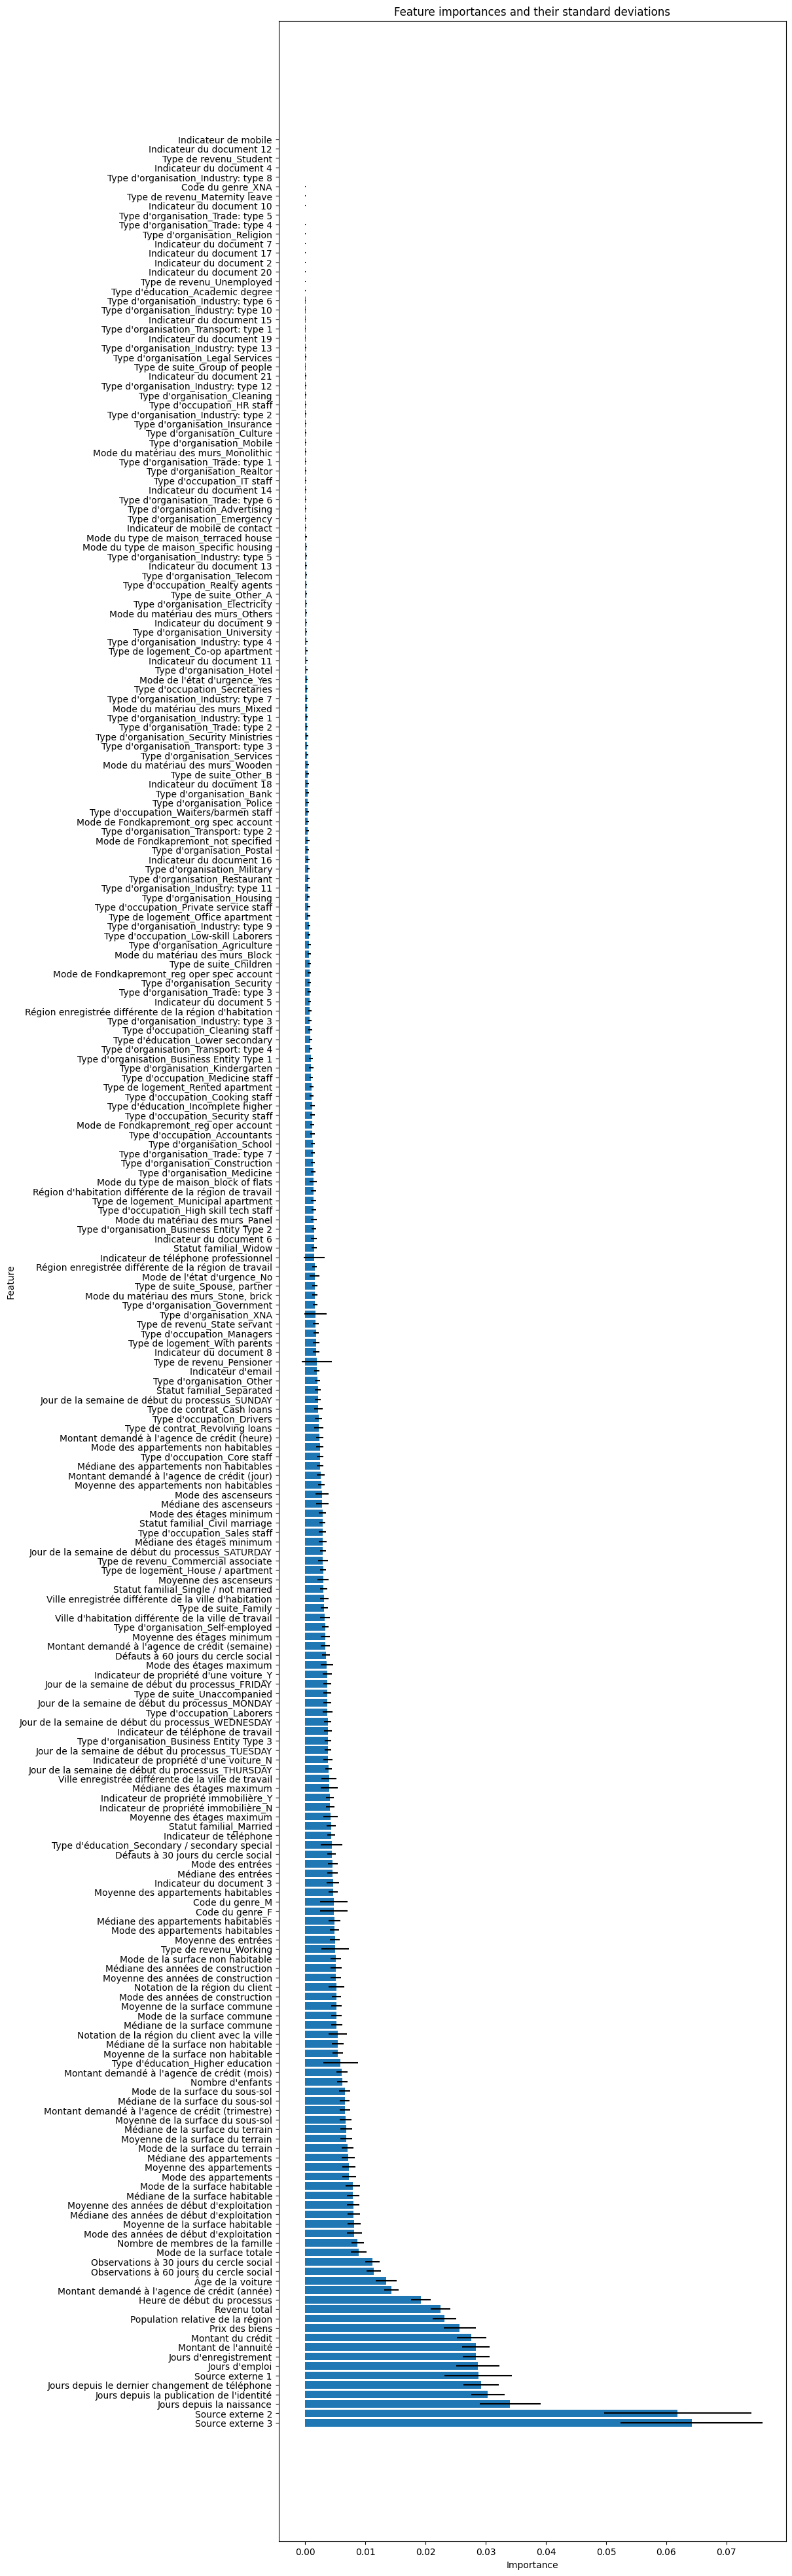

In [24]:
# Créer un DataFrame pour l'importance des caractéristiques et leurs écarts-types
df_importances = pd.DataFrame({
    'feature': X.columns,  # Remplacez ceci par les noms de vos caractéristiques si vous les avez
    'importance': importances,
    'std': std
})

# Trier le DataFrame par importance
df_importances = df_importances.sort_values('importance', ascending=False)

# Créer un graphique à barres avec des barres d'erreur
plt.figure(figsize=(10, 50))  # Ajustez la taille du graphique selon vos besoins
plt.barh(df_importances['feature'], df_importances['importance'], xerr=df_importances['std'], align='center')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importances and their standard deviations')

plt.show()


In [25]:
X = X[['Heure de début du processus',
  'Prix des biens',
   'Population relative de la région',
   'Source externe 1',
   'Revenu total',
   'Montant du crédit',
   "Jours d'emploi",
   'Jours depuis le dernier changement de téléphone',
   "Montant de l'annuité",
   "Jours d'enregistrement",
   "Jours depuis la publication de l'identité",
   'Jours depuis la naissance',
   'Source externe 3',
   'Source externe 2'
   ]]


In [26]:
X.shape

(49650, 14)

Text(0.5, 1.0, 'Corrélation')

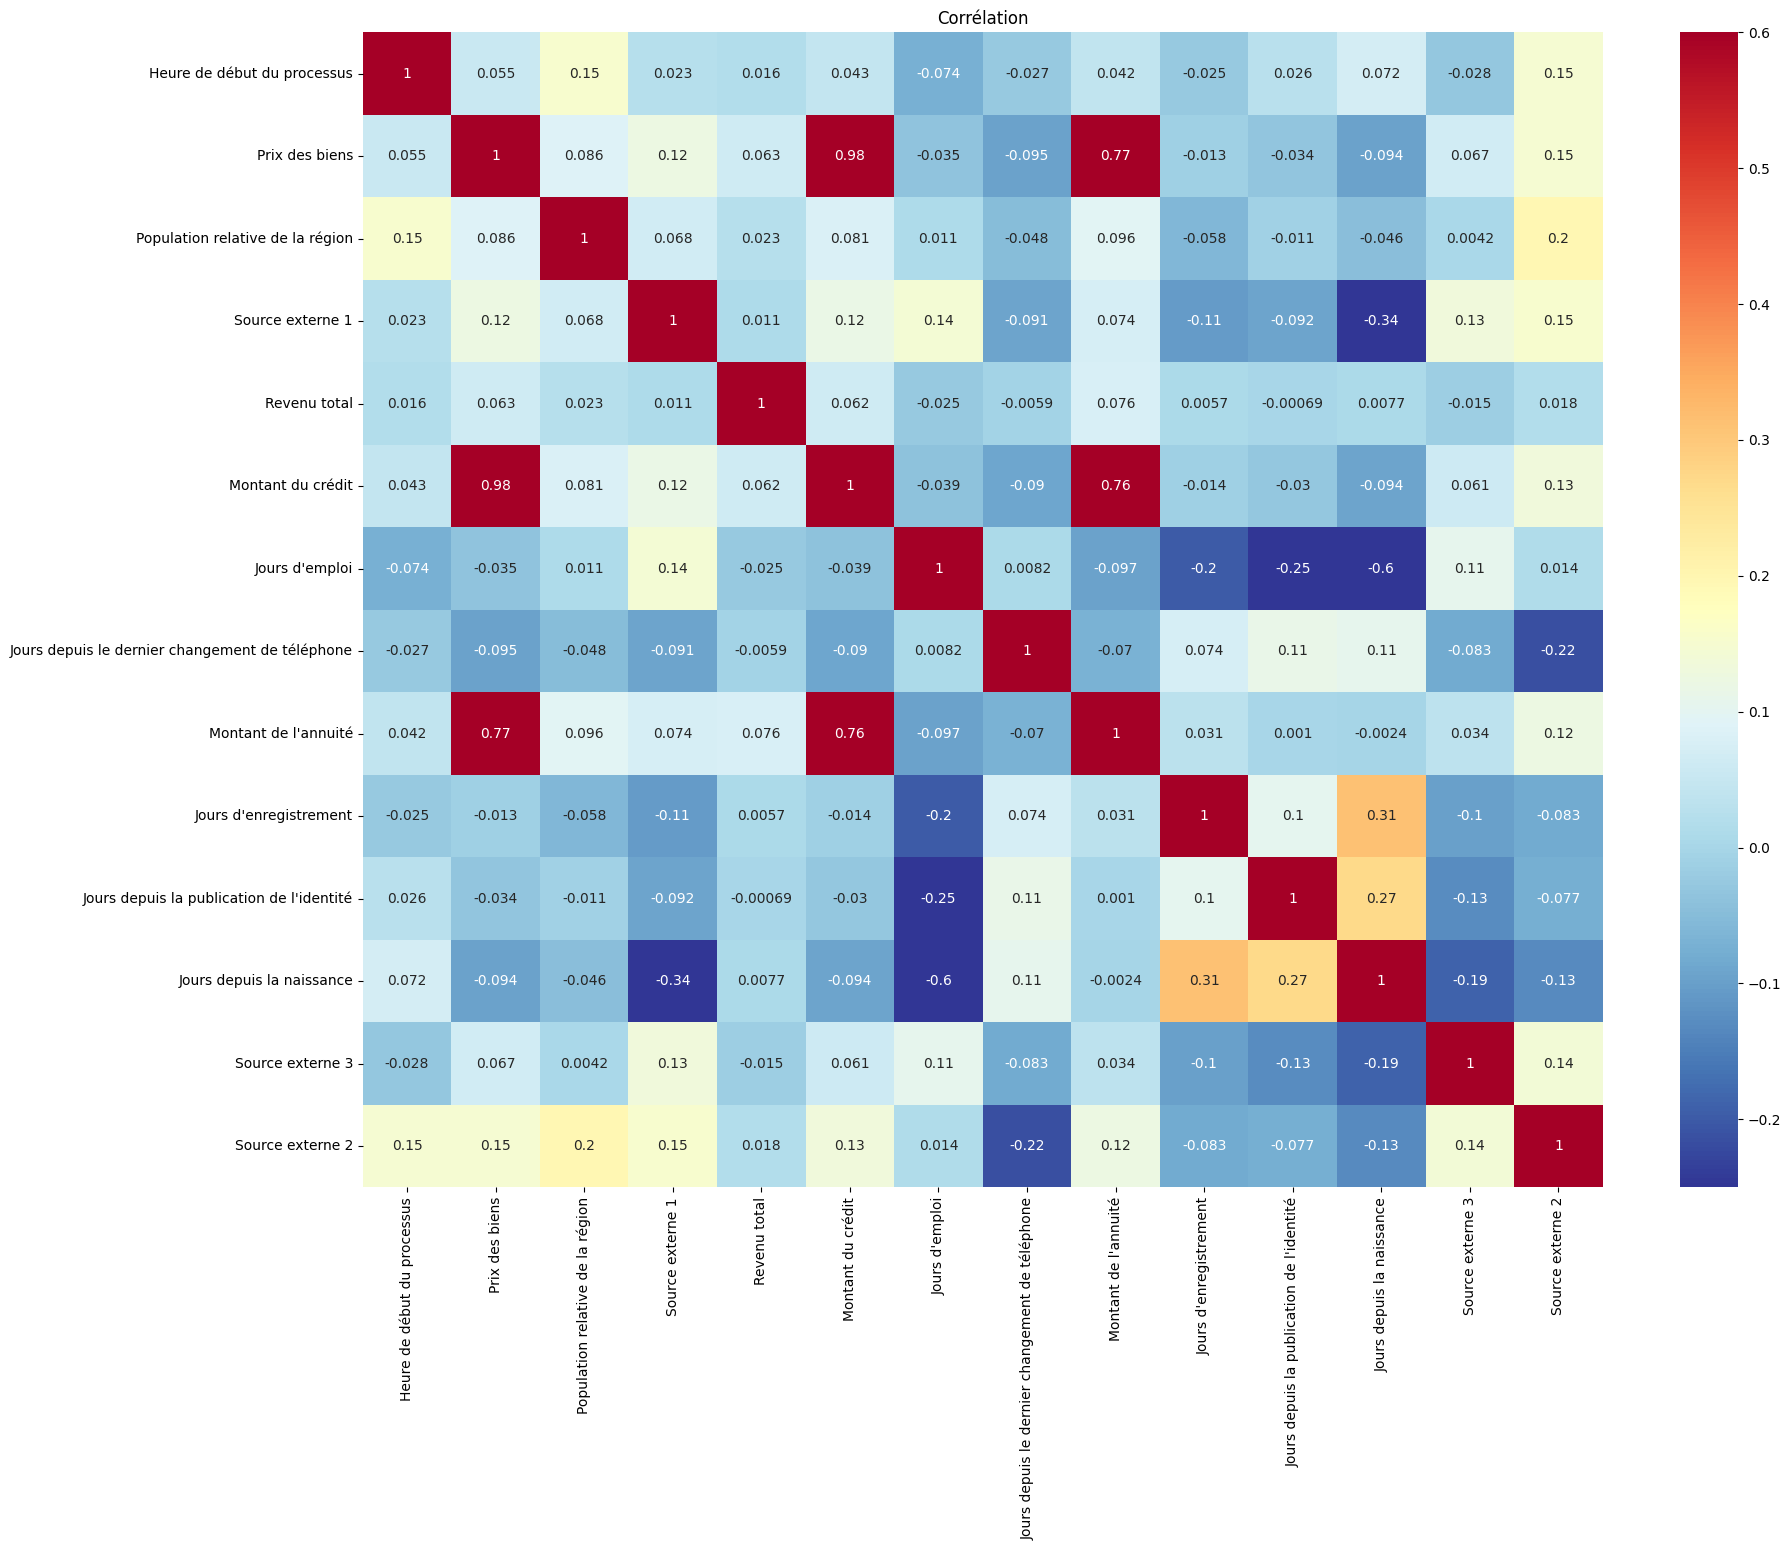

In [27]:
correl = X.corr()
plt.figure(figsize = (20, 15))

sns.heatmap(correl , cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Corrélation')



1.   Prix des biens et Montant du crédit sont fortement corrélés (0.986588). Nous pourrions envisager de supprimer l’une de ces variables pour éviter la redondance d’informations.
2.   Prix des biens et Montant de l’annuité ont également une forte corrélation (0.774661). Il pourrait être judicieux de ne conserver qu’une seule de ces variables.

3.   Jours d’emploi et Jours depuis la naissance sont fortement corrélés négativement (-0.615864). Cela signifie que plus une personne est âgée, moins elle a travaillé récemment. Nous pourrions envisager de supprimer l’une de ces variables.




Nous avons choisi de supprimer **Prix des biens** car elle est moins importante que Montant du crédit et Montant de l’annuité.Nous avons préféré supprimer **Jours d'emploi** car elle est moins importante que Jours depuis la naissance. Enfin nous supprimerons Montant du crédit car il est moins important que Montant de l'annuité.

In [28]:
X = X[['Heure de début du processus',
   'Population relative de la région',
   'Source externe 1',
   'Revenu total',
   'Jours depuis le dernier changement de téléphone',
   "Montant de l'annuité",
   "Jours d'enregistrement",
   "Jours depuis la publication de l'identité",
   'Jours depuis la naissance',
   'Source externe 3',
   'Source externe 2'
   ]]

Text(0.5, 1.0, 'Corrélation')

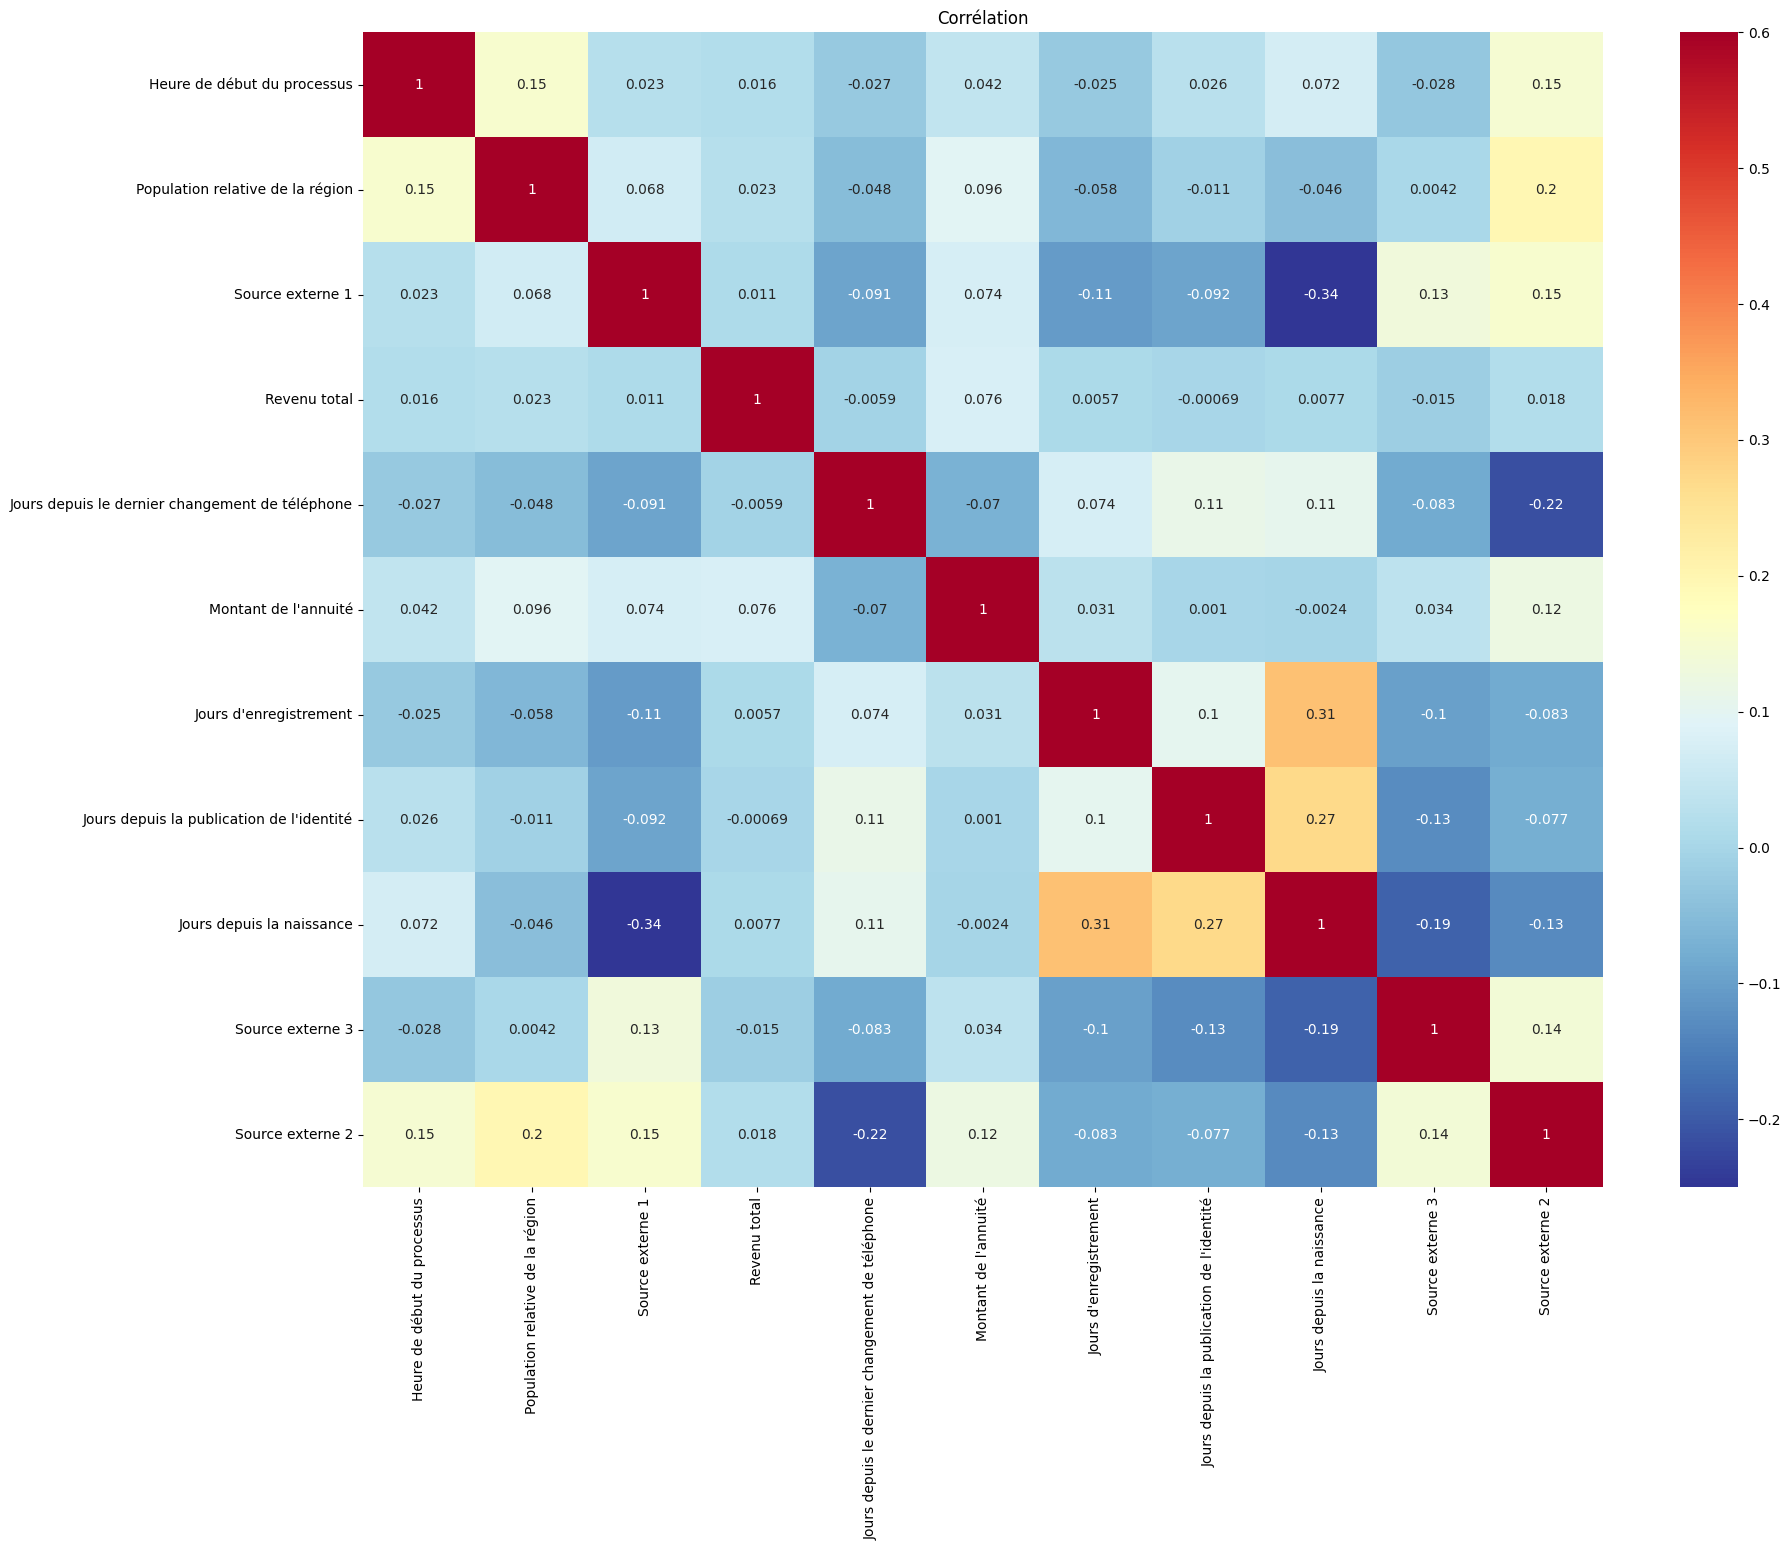

In [29]:
correl = X.corr()
plt.figure(figsize = (20, 15))

sns.heatmap(correl , cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Corrélation')

Normalisons les données pour éviter des bias à cause des différences d'échelles.

In [30]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [31]:
X = pd.DataFrame(X)

In [32]:
X

,0,1,2,3,4,5,6,7,8,9,10
0,-0.592841,-0.092016,-2.642062e+00,0.066078,-0.300494,-0.155527,0.320243,0.497429,1.400869,-1.718535,-0.984218
1,1.228491,1.222052,2.302527e+00,0.006945,-0.836442,1.068024,1.030940,1.484958,0.402399,0.186750,1.234033
2,0.014270,-0.104931,-1.190415e-15,-0.111321,1.115761,-0.048727,-0.480641,-0.651290,0.598300,-2.135981,-1.112057
3,0.014270,-0.368890,-1.190415e-15,-0.145112,-1.197080,-0.681564,1.086979,-0.715765,0.964428,0.108898,0.573045
4,-0.896396,-0.151722,-1.190415e-15,-0.102874,0.917911,0.019598,-0.533469,0.690198,-0.741551,-1.441237,0.389543
...,...,...,...,...,...,...,...,...,...,...,...
49645,-0.592841,-0.068814,5.733533e-01,-0.145112,-0.579738,0.347293,-0.088371,-0.324306,1.050468,1.399607,0.450556
49646,-0.592841,0.876888,3.169463e+00,0.175896,-0.707464,0.675983,1.339152,-0.677606,-1.126876,-0.647288,1.548639
49647,-0.289285,0.217263,-1.495283e+00,-0.102874,-1.779360,-0.666307,1.187965,-0.697344,0.843696,0.819976,0.162180
49648,0.924935,0.217263,-1.190415e-15,-0.102874,1.119518,-0.350884,-0.765795,0.341503,-2.050640,1.537965,-0.582750


In [33]:
name=['Heure de début du processus',
   'Population relative de la région',
   'Source externe 1',
   'Revenu total',
   'Jours depuis le dernier changement de téléphone',
   "Montant de l'annuité",
   "Jours d'enregistrement",
   "Jours depuis la publication de l'identité",
   'Jours depuis la naissance',
   'Source externe 3',
   'Source externe 2'
   ]
X.columns = name

Découpons notre ensemble de donnée en un d'entainement (80%) et un ensemble de test (20%)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train.shape

(39720, 11)

In [36]:
y_train.shape

(39720,)

In [37]:
X_test.shape

(9930, 11)

In [38]:
y_test.shape

(9930,)

Initialisons les paramêtres de notre modèle

Explication des choix

1. n_estimators = 500 : Un grand nombre d'arbres (500) permet d'obtenir une meilleure performance et une plus grande robustesse du modèle, surtout sur un jeu de données de cette taille.
2.   max_depth = 10 : Une profondeur maximale de 10 permet de capturer les interactions complexes dans les données tout en évitant le surapprentissage.


3.   min_samples_split = 10 : Ce paramètre empêche les arbres de se développer trop en profondeur sur des échantillons trop petits, ce qui améliore la généralisation.
4.  min_samples_leaf = 5 : Un minimum de 5 échantillons par feuille d'arbre assure une stabilité des prédictions et évite le surapprentissage.


5.   max_features = 'sqrt' : En limitant le nombre de features à la racine carrée du nombre total de features, on introduit de la diversité entre les arbres et on améliore la performance globale.







In [39]:
# Créer le modèle
rf_model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)



Entrainons le modèle.

In [40]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=1000, random_state=42)

Prédisons notre target.

In [41]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

Voyons nos métriques pour analyser les performances de notre modèle

## Permance du modèle sur les données d'entrainement.

## Précision au train
La précision (precision) est une métrique clé en classification qui mesure la proportion de vrais positifs parmi tous les éléments prédits comme positifs. Elle se calcule comme suit :
Précision = Vrais Positifs / (Vrais Positifs + Faux Positifs)

In [42]:
precision = precision_score(y_train, y_train_pred)
print(f"La précision est de : {precision:.2f}")

La précision est de : 0.66


## Accuracy au train
La précision (accuracy) est une métrique clé en classification qui mesure la proportion d'éléments correctement prédits par rapport à l'ensemble des éléments.

In [43]:
accuracy = accuracy_score(y_train, y_train_pred)
print(f"La justesse est de : {accuracy:.2f}")

La justesse est de : 0.66


## Recall au train
Le recall (rappel) est une métrique clé en classification qui mesure la proportion d'éléments positifs correctement prédits par rapport à l'ensemble des éléments positifs réels. Il se calcule comme suit :
Recall = Vrais Positifs / (Vrais Positifs + Faux Négatifs)

In [44]:
recall = recall_score(y_train, y_train_pred)
print(f"Le recall est de : {recall:.2f}")

Le recall est de : 0.68


## F1 score au train
Le f1_score est une métrique très utile pour évaluer les performances des modèles de classification, en particulier lorsque les classes sont déséquilibrées. Il combine la précision (precision) et le rappel (recall) en une seule valeur comprise entre 0 et 1.

In [45]:
f1 = f1_score(y_train, y_train_pred)
print(f"Le f1_score est de : {f1:.2f}")

Le f1_score est de : 0.67


## Permance du modèle sur les données de test.

## Précision au test

In [46]:
precision = precision_score(y_test, y_test_pred)
print(f"La précision est de : {precision:.2f}")

La précision est de : 0.67


## Accuracy au test

In [47]:
accuracy = accuracy_score(y_test, y_test_pred)
print(f"La justesse est de : {accuracy:.2f}")

La justesse est de : 0.68


## Recall au test

In [48]:
recall = recall_score(y_test, y_test_pred)
print(f"Le recall est de : {recall:.2f}")

Le recall est de : 0.69


### F1 score au test

In [49]:
f1 = f1_score(y_test, y_test_pred)
print(f"Le f1_score est de : {f1:.2f}")

Le f1_score est de : 0.68


In [50]:
X_train.to_csv('data/X_train.csv',index=False)
y_train.to_csv('data/y_train.csv',index=False)
X_test.to_csv('data/X_test.csv',index=False)
y_test.to_csv('data/y_test.csv',index=False)

In [51]:
joblib.dump(rf_model, 'data/random_forest_model.pkl')

['data/random_forest_model.pkl']